In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [5]:
url = 'https://raw.githubusercontent.com/FourLevel/Machine-Learning-and-Financial-Applications/cf22b9f6ee9767fd1348d87fb2d96f7beba52e4c/Sup.%20Learning%20-%20Regression%20and%20Time%20Series%20models%20Case%201-20250225/dataset.csv'
df = pd.read_csv(url)

df.head()

,date,value
0,1991/7/1,3.526591
1,1991/8/1,3.180891
2,1991/9/1,3.252221
3,1991/10/1,3.611003
4,1991/11/1,3.565869


In [6]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.145186
p-value: 1.000000


Since p-value(1.00) is greater than the significance level(0.05), let’s difference the series and see how the autocorrelation plot looks like.

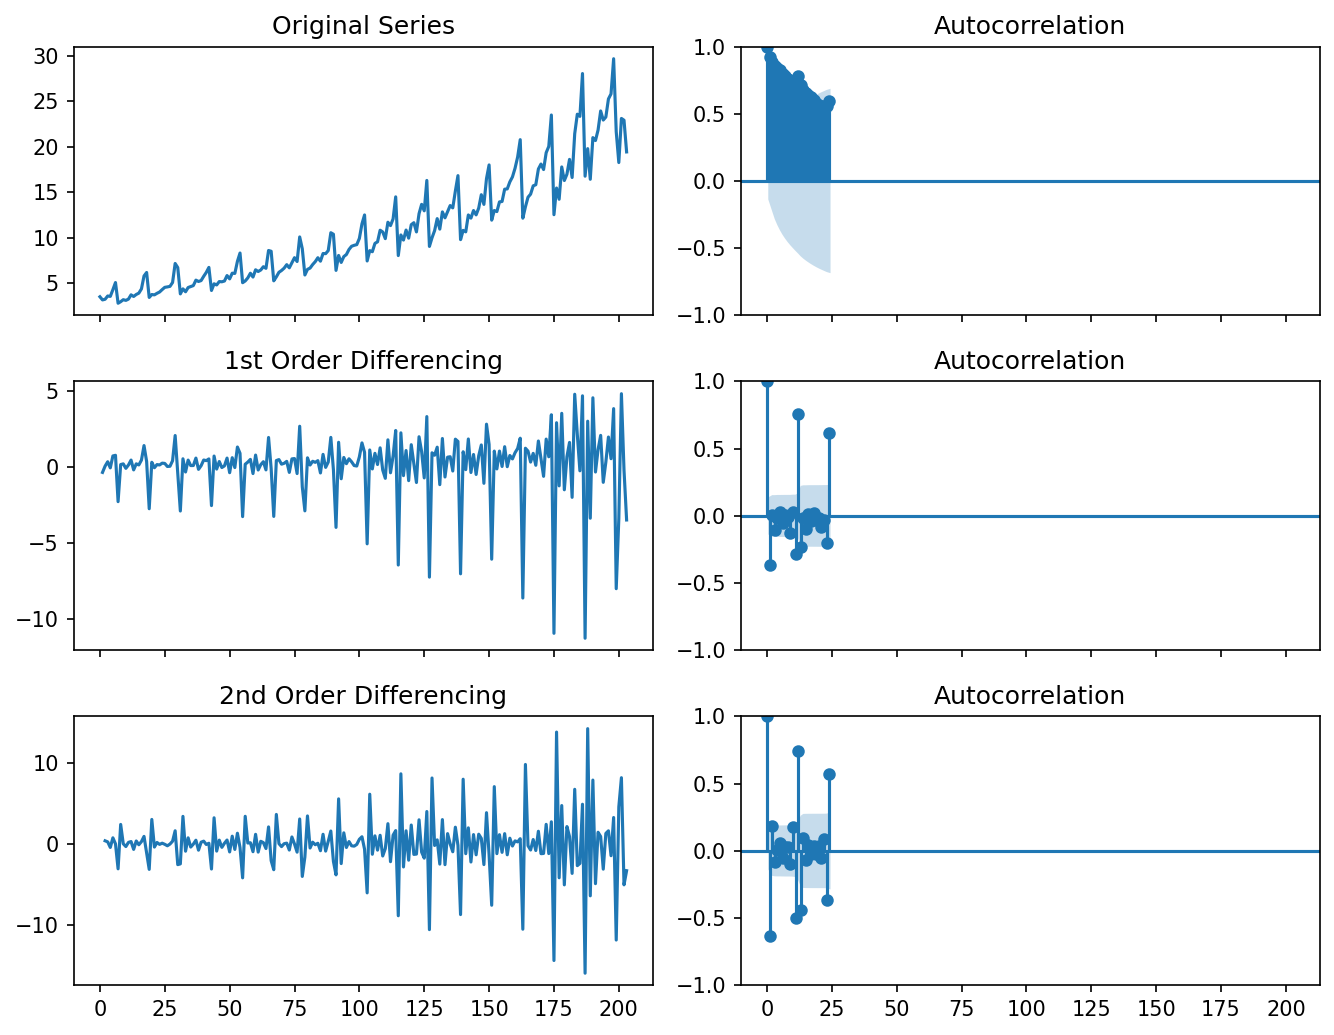

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':150})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()
plt.show()

For the above data, we can see that the time series reaches stationarity with two orders of differencing.

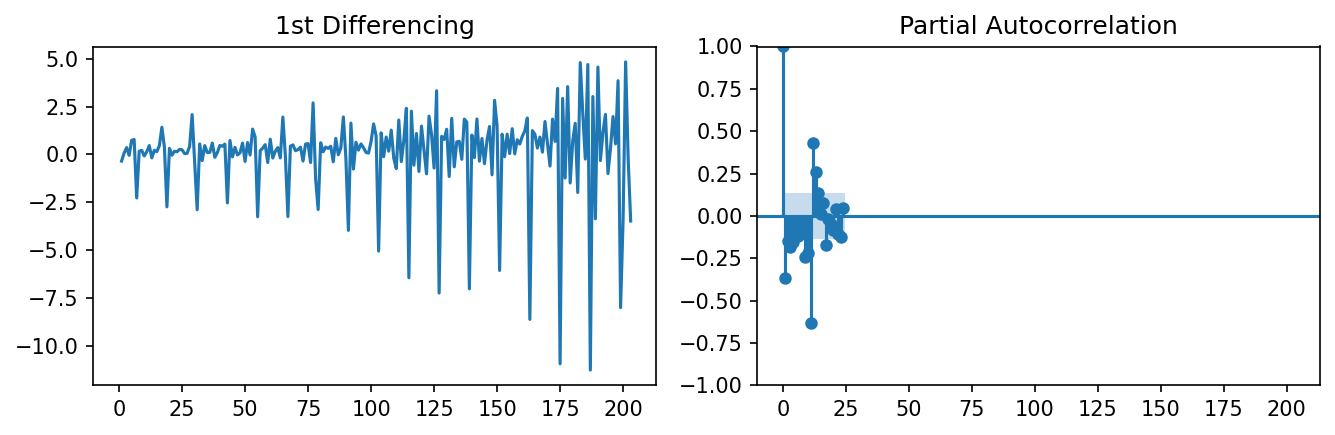

In [14]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':150})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.tight_layout()
plt.show()

We can see that the PACF lag 1 is quite significant since it is well above the significance line. So, we will fix the value of p as 1.

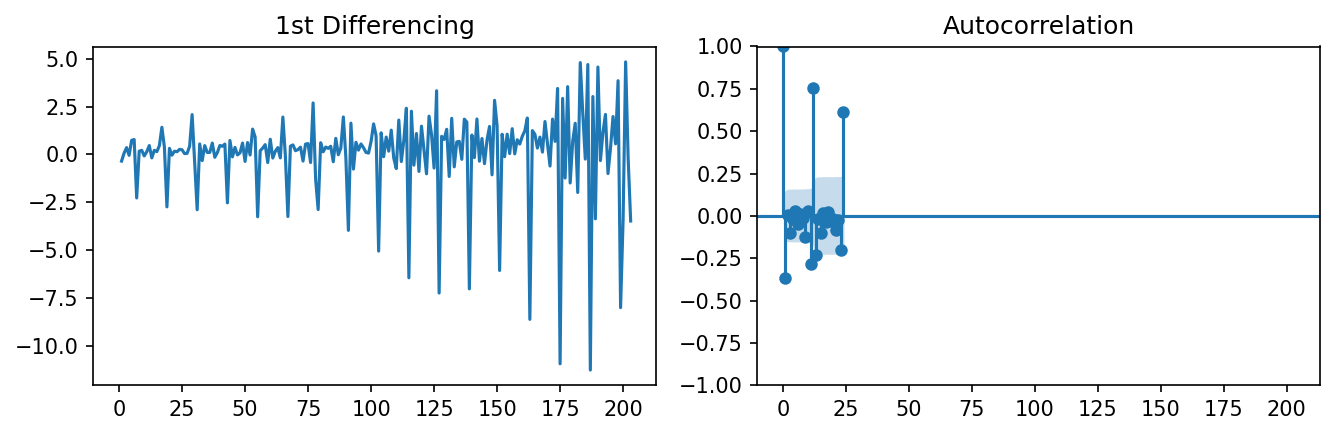

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':150})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.tight_layout()
plt.show()

We can see that couple of lags are well above the significance line. So, we will fix q as 2. If there is any doubt, we will go with the simpler model that sufficiently explains the Y.

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -424.570
Date:                Tue, 04 Mar 2025   AIC                            857.140
Time:                        02:45:54   BIC                            870.393
Sample:                             0   HQIC                           862.502
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4178      0.356      1.174      0.240      -0.280       1.115
ma.L1         -0.9546      0.377     -2.531      0.011      -1.694      -0.215
ma.L2          0.0969      0.272      0.356      0.7

The model summary provides lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

The coefficient of the ma.L2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

So, we will rebuild the model without the ma.L2 term.

In [18]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -424.762
Date:                Tue, 04 Mar 2025   AIC                            855.524
Time:                        02:52:23   BIC                            865.463
Sample:                             0   HQIC                           859.545
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3009      0.094      3.195      0.001       0.116       0.485
ma.L1         -0.8300      0.048    -17.204      0.000      -0.925      -0.735
sigma2         3.8327      0.259     14.790      0.0

The model AIC has slightly reduced, which is good. The p-values of the ar.L1 and ma.L1 terms have improved and are highly significant (<< 0.05).

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

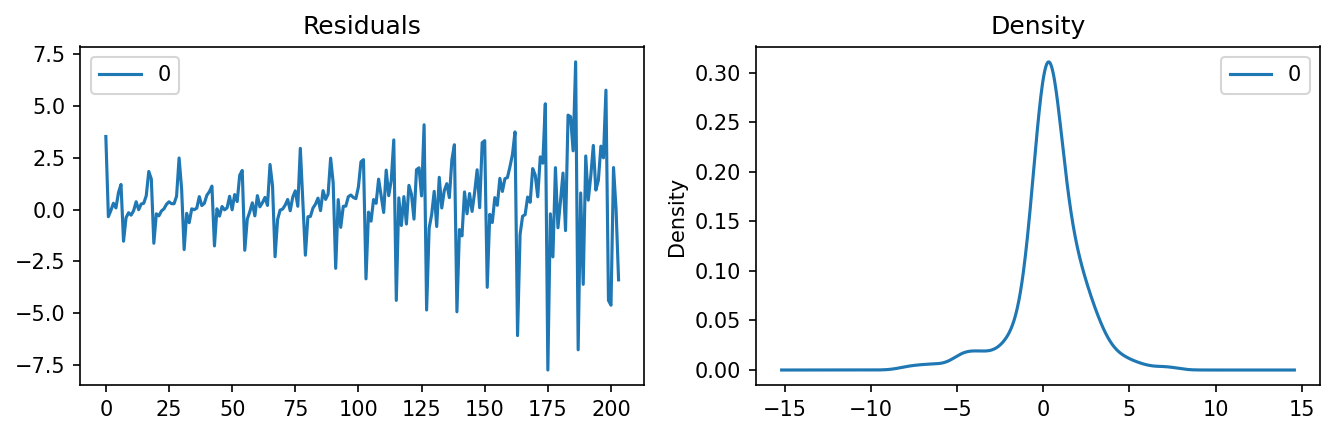

In [23]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':150})
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

plt.tight_layout()
plt.show()